<a href="https://colab.research.google.com/github/bengisudurugoksu/AnomalyDetectioninTimeSeries/blob/main/finance/i-transformer_finance_testing/i_transformer_finance_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Google Drive mounted.


/tmp/ipython-input-520323505.py:95: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(ticker, start="2021-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


✅ Loaded model: /content/drive/MyDrive/anomaly_project/models/itransformer_finance_best.h5
📊 Test dataframe shape: (502, 9)
🪟 Final test shape: (438, 64, 9)
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
🔎 Example MSE: [1.38895908e+15 1.38610305e+15 1.36410612e+15 1.35776972e+15
 1.35303244e+15 1.34874558e+15 1.34792596e+15 1.34680674e+15
 1.34810148e+15 1.34208611e+15]
📌 Threshold: 1518203838993064.2
🚨 Anomaly count: 0


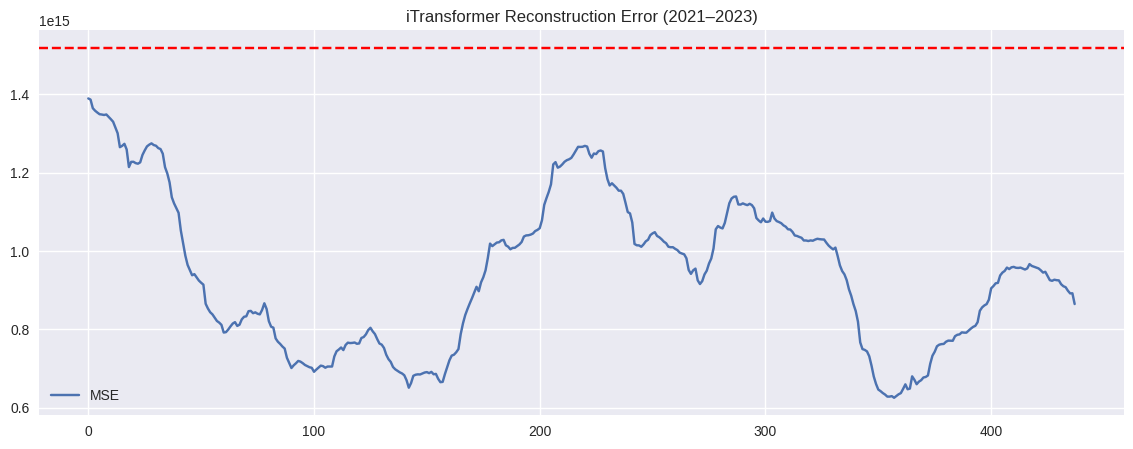

<Figure size 1400x600 with 0 Axes>

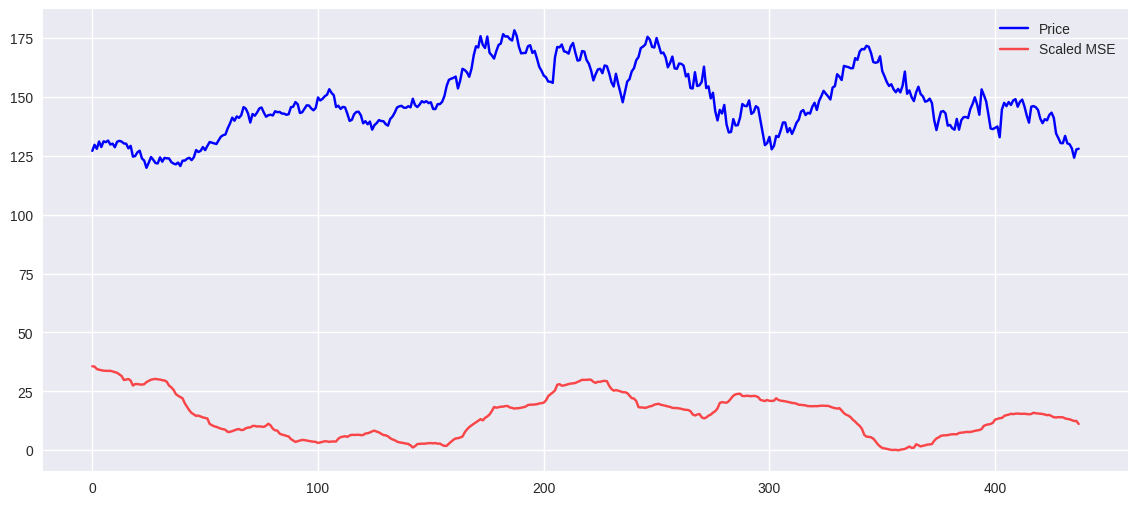

/tmp/ipython-input-520323505.py:178: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


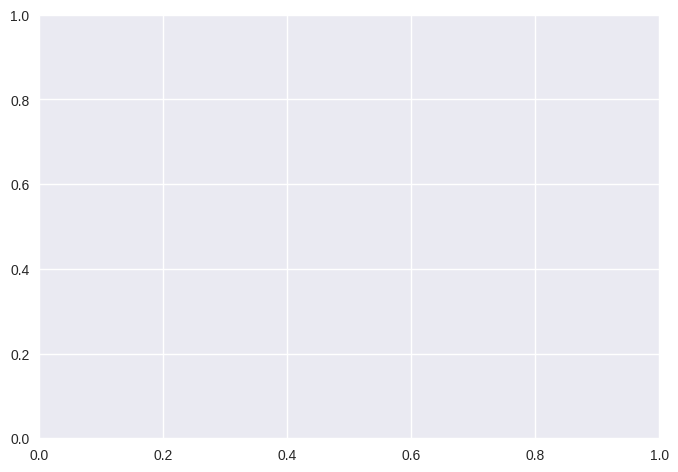

In [5]:
# ============================================================
# 1) MOUNT DRIVE
# ============================================================
from google.colab import drive
drive.mount('/content/drive')
print("📂 Google Drive mounted.")


# ============================================================
# 2) IMPORTS (ONLY TENSORFLOW.KERAS!)
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import register_keras_serializable

plt.style.use("seaborn-v0_8")


# ============================================================
# 3) CUSTOM TRANSFORMER LAYER (EXACT SAME AS TRAINING)
# ============================================================
@register_keras_serializable()
class iTransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        x = self.att(inputs, inputs, training=training)
        x = self.dropout1(x, training=training)
        x = self.norm1(inputs + x)

        f = self.ffn(x, training=training)
        f = self.dropout2(f, training=training)
        return self.norm2(x + f)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config



# ============================================================
# 4) LOAD TRAINED MODEL (H5 SAFE LOAD)
# ============================================================
model_path = "/content/drive/MyDrive/anomaly_project/models/itransformer_finance_best.h5"

itransformer = keras.models.load_model(
    model_path,
    custom_objects={
        "iTransformerBlock": iTransformerBlock,
        "mse": MeanSquaredError(),         # ← CRUCIAL FIX
        "MeanSquaredError": MeanSquaredError
    }
)

print("✅ Loaded model:", model_path)



# ============================================================
# 5) LOAD STOCK DATA (AAPL)
# ============================================================
ticker = "AAPL"

df_test = yf.download(ticker, start="2021-01-01", end="2023-01-01")
df_test = df_test[["Open", "High", "Low", "Close", "Volume"]]

df_test["HL"] = df_test["High"] - df_test["Low"]
df_test["OC"] = df_test["Close"] - df_test["Open"]
df_test["RET"] = df_test["Close"].pct_change()
df_test["VOL_RET"] = df_test["Volume"].pct_change()
df_test = df_test.dropna()


print("📊 Test dataframe shape:", df_test.shape)



# ============================================================
# 6) CREATE WINDOWS (SEQ=64, FEATURES=9)
# ============================================================
SEQ_LEN = 64

def create_windows(arr):
    X = []
    for i in range(len(arr) - SEQ_LEN):
        X.append(arr[i:i+SEQ_LEN])
    return np.array(X)

X_test = create_windows(df_test.values)

print("🪟 Final test shape:", X_test.shape)



# ============================================================
# 7) INFERENCE
# ============================================================
recon = itransformer.predict(X_test, verbose=1)
mse = np.mean((X_test - recon)**2, axis=(1,2))

print("🔎 Example MSE:", mse[:10])



# ============================================================
# 8) ANOMALY THRESHOLD
# ============================================================
threshold = mse.mean() + 3*mse.std()
anomalies = mse > threshold

print("📌 Threshold:", threshold)
print("🚨 Anomaly count:", anomalies.sum())



# ============================================================
# 9) PLOT — MSE
# ============================================================
plt.figure(figsize=(14,5))
plt.plot(mse, label="MSE")
plt.axhline(threshold, color="red", linestyle="--")

plt.scatter(np.where(anomalies)[0], mse[anomalies], color="red", s=30)
plt.title("iTransformer Reconstruction Error (2021–2023)")
plt.legend()
plt.show()



# ============================================================
# 10) PLOT — PRICE vs MSE (Overlay)
# ============================================================
plt.figure(figsize=(14,6))
# PRICE SERIES aligned with windows
price = df_test["Close"].values[SEQ_LEN:]

# SCALE MSE for visualization
scaled_mse = (mse - mse.min()) / (mse.max() - mse.min())
scaled_mse = scaled_mse * (price.max() * 0.2)

plt.figure(figsize=(14,6))
plt.plot(price, label="Price", color="blue")
plt.plot(scaled_mse, label="Scaled MSE", color="red", alpha=0.7)
plt.legend()
plt.show()

plt.legend()
plt.show()


/tmp/ipython-input-1957831573.py:58: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("SPY", start="2019-09-01", end="2020-07-01")
[*********************100%***********************]  1 of 1 completed


Model loaded: /content/drive/MyDrive/anomaly_project/models/itransformer_finance_best.h5
(208, 9)
X_test: (144, 64, 9)
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step
Percentile threshold: 4451925368847023.5
Anomaly count: 4


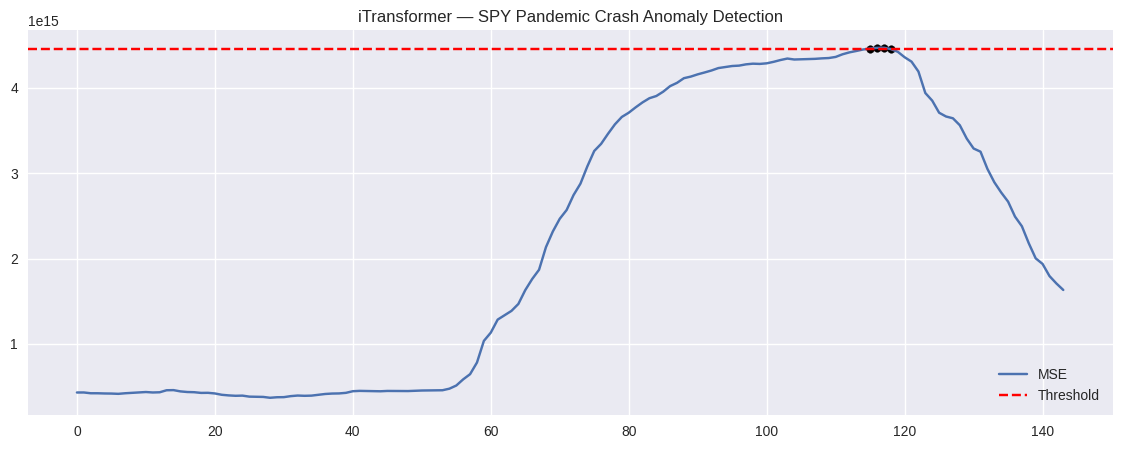

/tmp/ipython-input-1957831573.py:120: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  scale_factor = float(df["Close"].max()) * 0.3


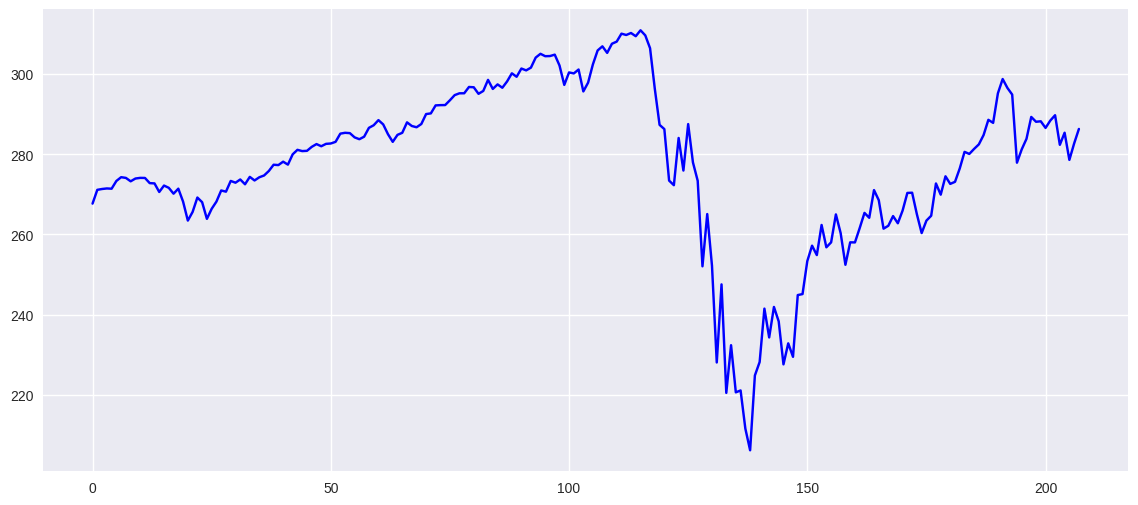

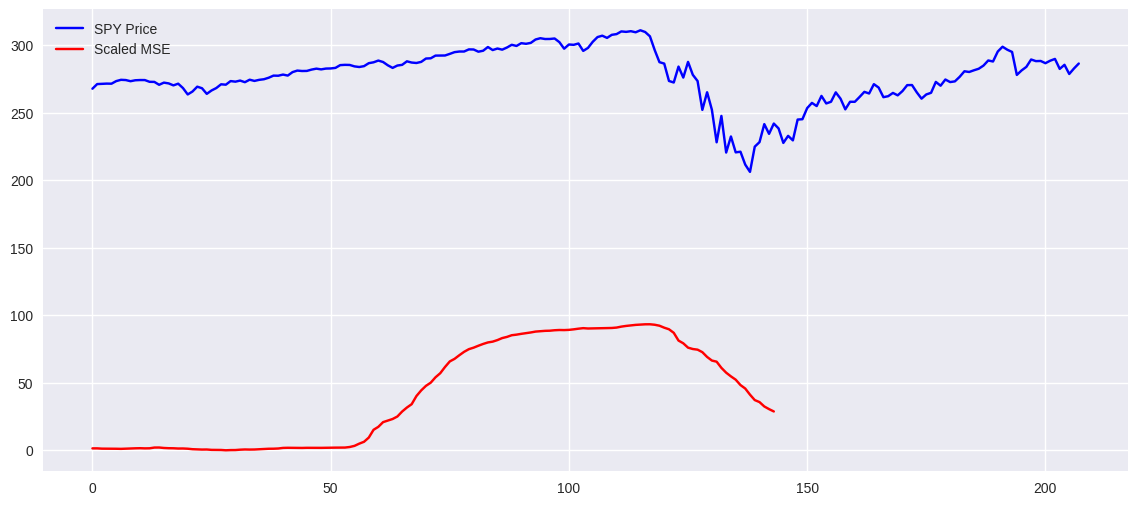

In [9]:
# ============================================================
# 1) LOAD MODEL
# ============================================================
from tensorflow import keras
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import register_keras_serializable
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

@register_keras_serializable()
class iTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            keras.layers.Dense(ff_dim, activation="relu"),
            keras.layers.Dense(embed_dim),
        ])
        self.norm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=None):
        x = self.att(inputs, inputs)
        x = self.dropout1(x)
        x = self.norm1(inputs + x)

        f = self.ffn(x)
        f = self.dropout2(f)
        return self.norm2(x + f)

# load model
model_path = "/content/drive/MyDrive/anomaly_project/models/itransformer_finance_best.h5"

model = keras.models.load_model(
    model_path,
    custom_objects={
        "iTransformerBlock": iTransformerBlock,
        "mse": MeanSquaredError(),
        "MeanSquaredError": MeanSquaredError
    }
)

print("Model loaded:", model_path)


# ============================================================
# 2) DOWNLOAD SPY PANDEMIC CRASH DATA
# ============================================================
df = yf.download("SPY", start="2019-09-01", end="2020-07-01")
df = df[["Open", "High", "Low", "Close", "Volume"]]

df["HL"] = df["High"] - df["Low"]
df["OC"] = df["Close"] - df["Open"]
df["RET"] = df["Close"].pct_change()
df["VOL_RET"] = df["Volume"].pct_change()

df = df.dropna()
print(df.shape)


# ============================================================
# 3) WINDOWING (64, 9)
# ============================================================
def create_windows(arr, seq=64):
    X = []
    for i in range(len(arr) - seq):
        X.append(arr[i:i+seq])
    return np.array(X)

X_test = create_windows(df.values)
print("X_test:", X_test.shape)


# ============================================================
# 4) RECONSTRUCTION ERROR
# ============================================================
recon = model.predict(X_test, verbose=1)
mse = np.mean((X_test - recon)**2, axis=(1,2))

# =========================================
# THRESHOLD (Percentile-Based)
# =========================================
threshold = np.percentile(mse, 97.5)
print("Percentile threshold:", threshold)

anomalies = mse > threshold
print("Anomaly count:", anomalies.sum())

# =========================================
# PLOT MSE + THRESHOLD
# =========================================
plt.figure(figsize=(14,5))
plt.plot(mse, label="MSE")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.scatter(np.where(anomalies)[0], mse[anomalies], color="black", s=30)
plt.legend()
plt.title("iTransformer — SPY Pandemic Crash Anomaly Detection")
plt.show()

# =========================================
# PLOT PRICE + ANOMALY
# =========================================
plt.figure(figsize=(14,6))
plt.plot(df["Close"].values, label="SPY Price", color="blue")

# ================================
# SCALE MSE (no length mismatch)
# ================================
scaled_mse = (mse - mse.min()) / (mse.max() - mse.min())

scale_factor = float(df["Close"].max()) * 0.3
scaled_mse = scaled_mse * scale_factor

plt.figure(figsize=(14,6))
plt.plot(df["Close"].values, label="SPY Price", color="blue")
plt.plot(scaled_mse, label="Scaled MSE", color="red")
plt.legend()
plt.show()


